# Lecture 3 笔记导读与目标

- 目标: 用可运行示例理解前向/反向、梯度累积与清零、autograd 追踪与分离。
- 重点: VJP 视角、`no_grad/torch.inference_mode`、常见 debug 技巧与 A0 作业对应关系。
- 建议: 逐格运行，观察 `.grad` 的变化与形状是否匹配预期。


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子以便结果可复现
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
print(f"MPS可用: {torch.backends.mps.is_available()}")

PyTorch版本: 2.8.0
CUDA可用: False
MPS可用: True


## Autograd 与计算图（动态）

- 动态计算图: 前向即时构图，`requires_grad=True` 的张量会被追踪。
- 叶子/非叶子: 叶子张量的梯度累计在 `.grad`；中间结果有 `grad_fn`。
- 小贴士: 可打印 `tensor.grad_fn`, `tensor.is_leaf`，必要时对中间量调用 `retain_grad()` 便于调试。


## 工程视角：Autograd 你需要知道的（对照讲义）

- 动态计算图：前向即时构图；非叶子 `grad_fn`，叶子 `.grad`。
- 反向实现（提示）：背后采用反向模式自动微分（VJP），无需显式构造雅可比；详见 PyTorch Autograd 文档。
- 非标量 backward：`y.backward(gradient=v)`，`v` 与 `y` 同形，表示上游权重（仅在无显式标量损失时需要）。
- 线性层 backward：设上游梯度 `G=∂L/∂Y`，`dX = G @ W.T`，`dW = X.T @ G`，`db = G.sum(批/序列维)`。
- 训练循环要点：`zero_grad()`、避免对中间量原地写、参数更新放优化器/`no_grad()`。
- 高阶/多次反传：`create_graph=True`、`retain_graph=True` 仅在需要时使用。
- 性能/调试：AMP、checkpoint、`torch.compile`、hooks 与图打印。


### 叶子 vs 非叶子，与 `.grad` / `.grad_fn`

- 叶子张量: 用户直接创建且 `requires_grad=True`，无 `grad_fn`，反传后 `.grad` 有值；
- 非叶子张量: 由运算产生，默认不保留 `.grad`（需 `retain_grad()` 才能查看），但有 `grad_fn`；
- `is_leaf` 可用于快速判断。

In [19]:
import torch
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)  # 叶子
y = 2 * x                                             # 非叶子
print('x: is_leaf=', x.is_leaf, ', grad_fn=', x.grad_fn)
print('y: is_leaf=', y.is_leaf, ', grad_fn=', y.grad_fn)

# 默认非叶子不保留 .grad，调用 retain_grad() 以便教学观察
y.retain_grad()
loss = y.sum()
loss.backward()
print('x.grad:', x.grad)
print('y.grad (retained):', y.grad)


x: is_leaf= True , grad_fn= None
y: is_leaf= False , grad_fn= <MulBackward0 object at 0x322e3b9a0>
x.grad: tensor([2., 2., 2.])
y.grad (retained): tensor([1., 1., 1.])


### 非标量 backward 需要 `gradient` 参数（VJP 视角）

- 对非标量张量 `y` 调用 `y.backward()` 会报错；
- 需要提供与 `y` 同形的上游向量 `v`：`y.backward(gradient=v)`。

In [20]:
import torch
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x ** 2  # 非标量输出 shape=(3,)
try:
    y.backward()
except Exception as e:
    print('直接 backward 报错:', e)

v = torch.ones_like(y) / y.numel()
print(v)
y.backward(gradient=v)
print('提供 gradient 后 x.grad:', x.grad)


直接 backward 报错: grad can be implicitly created only for scalar outputs
tensor([0.3333, 0.3333, 0.3333])
提供 gradient 后 x.grad: tensor([0.6667, 1.3333, 2.0000])


### 高阶梯度与 `create_graph`

- 若需对一阶梯度再求梯度，需在第一次求导时设置 `create_graph=True`；
- 否则一阶梯度视作常量，无法继续反向。

In [4]:
import torch
x = torch.tensor(3.0, requires_grad=True)
y = x**3
# 一阶梯度：dy/dx = 3x^2
(g1,) = torch.autograd.grad(y, x, create_graph=True)
# 二阶梯度：d^2y/dx^2 = 6x
(g2,) = torch.autograd.grad(g1, x)
print('g1=', float(g1), ' g2=', float(g2))


g1= 27.0  g2= 18.0


/var/folders/40/jq_2qkcx61g630p7m3660fvw0000gn/T/ipykernel_65594/3111930888.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print('g1=', float(g1), ' g2=', float(g2))


### 原地修改与版本计数（常见错误示例）

- 对反向所需的张量做原地修改会触发版本计数错误；
- 正确做法：参数更新放在优化器或 `with torch.no_grad():` 里，避免修改中间变量。

In [5]:
import torch
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x * 2
loss = y.sum()
# 错误：在建立好计算图后修改叶子 x 会破坏反向所需历史
try:
    x.add_(1.0)
    loss.backward()
except Exception as e:
    print('原地修改导致错误:', e)


原地修改导致错误: a leaf Variable that requires grad is being used in an in-place operation.


### 多次 backward 与 `retain_graph`

- 默认反向后会释放计算图；再次反向需 `retain_graph=True` 或重新前向；
- 仅当确有需要时才保留计算图（更占内存）。

In [ ]:
import torch
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = (x**2).sum()
# 第一次 OK
y.backward(retain_graph=False)
print('第一次 x.grad:', x.grad)
# 第二次如不保留图会报错；上面已设置 retain_graph=True，可再次反向
y.backward()
print('第二次 x.grad (累加):', x.grad)


第一次 x.grad: tensor([2., 4., 6.])
第二次 x.grad (累加): tensor([ 4.,  8., 12.])


## 打印/可视化计算图：推荐方案

- 小模型用“文本遍历”观察 `grad_fn` 链接关系，轻量无依赖；
- 需要图形时优先 `torchviz`（可选依赖），仅用于玩具示例；
- 复杂网络更建议用 `torch.fx` 查看前向计算图，配合梯度 hook 观测反向流。

In [7]:
# 轻量 autograd 图遍历（从 loss.grad_fn 出发）
from collections import deque
import torch

def _fn_name(fn):
    return fn.__class__.__name__

def print_autograd_graph(loss, max_nodes=60):
    root = loss.grad_fn
    if root is None:
        print('loss.grad_fn is None (可能未构图或使用了 no_grad)')
        return
    q = deque([(root, 0)])
    seen = set()
    count = 0
    while q and count < max_nodes:
        fn, d = q.popleft()
        if fn in seen:
            continue
        seen.add(fn)
        indent = '  ' * d
        print(f"{indent}• { _fn_name(fn) }")
        count += 1
        # next_functions: list[(Function, idx)]
        for nxt, _ in getattr(fn, 'next_functions', []):
            if nxt is not None and nxt not in seen:
                q.append((nxt, d+1))
        # 可选：打印保存的张量信息
        st = getattr(fn, 'saved_tensors', None)
        if st:
            for t in st:
                try:
                    print(f"{indent}   ⤷ saved tensor: shape={tuple(t.shape)}, dtype={t.dtype}")
                except Exception:
                    pass

# 示例：两层线性网络
model = torch.nn.Sequential(torch.nn.Linear(4, 3), torch.nn.ReLU(), torch.nn.Linear(3, 2))
x = torch.randn(5, 4, requires_grad=True)
y = model(x)
loss = (y**2).mean()
print_autograd_graph(loss)


• MeanBackward0
  • PowBackward0
    • AddmmBackward0
      • AccumulateGrad
      • ReluBackward0
      • TBackward0
        • AddmmBackward0
        • AccumulateGrad
          • AccumulateGrad
          • AccumulateGrad
          • TBackward0
            • AccumulateGrad


### 可选：用 torchviz 生成图片

- 需要安装 `torchviz` 与本地 `graphviz`；环境不具备时可跳过。
- 仅在小图上使用，避免渲染巨型网络导致卡顿。

### torchviz 显示
- 下面的单元提供 SVG/PNG 双重回退，并把图保存为文件以便查看。

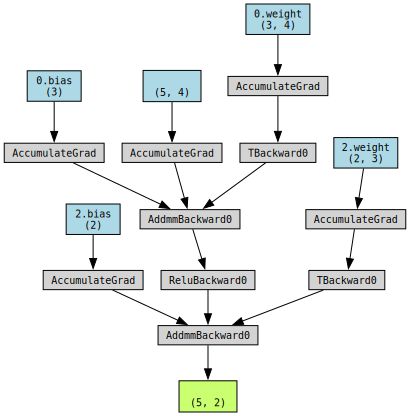

已保存图到: torchviz_graph.svg


In [8]:
# 尝试用多种方式在 Jupyter 中显示，并保存为文件
try:
    from torchviz import make_dot
    from IPython.display import display, SVG, Image
    import os
    dot = make_dot(y, params=dict(model.named_parameters()))
    # 方式1：直接 display 对象（若已配置 _repr_svg_）
    try:
        display(dot)
    except Exception:
        pass
    
    # 同步保存为文件
    out_base = 'torchviz_graph'
    try:
        path = dot.render(out_base, format='svg', cleanup=True)
        print('已保存图到:', path)
    except Exception as e:
        print('保存 SVG 失败:', e)
        try:
            path = dot.render(out_base, format='png', cleanup=True)
            print('已保存图到:', path)
        except Exception as e2:
            print('保存 PNG 失败:', e2)
except Exception as e:
    print('无法生成/显示图：', e)
    print('请确认已安装:pip install torchviz graphviz并在系统层安装 Graphviz 可执行 (dot)。')


In [9]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layer1 = torch.nn.Linear(DIM_IN, HIDDEN_SIZE)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(HIDDEN_SIZE, DIM_OUT)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

## 实验任务与网络结构

- 本笔记用一个两层线性网络演示训练流程与梯度传播。
- 观察点: 参数的初值/更新前后变化、`.grad` 在 `backward()` 前后的状态。
- 记住: `.grad` 默认累积，优化步前需要清零（见后文）。


In [10]:
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

tensor([ 0.0942, -0.0014, -0.0744, -0.0871,  0.0799, -0.0731,  0.0754,  0.0048,
        -0.0830,  0.0596], grad_fn=<SliceBackward0>)
None


In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(164.9760, grad_fn=<SumBackward0>)


## 训练三步与梯度流

1. 前向: `prediction = model(x)` 计算损失 `loss`；
2. 反向: `loss.backward()` 计算参数与输入的梯度；
3. 更新: `optimizer.step()` 使用梯度更新参数；

- 清零: 每次迭代前 `optimizer.zero_grad()`，否则 `.grad` 会累加。
- 形状: 梯度的形状与对应张量一致，注意广播导致的求和维度。


In [12]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([ 0.0942, -0.0014, -0.0744, -0.0871,  0.0799, -0.0731,  0.0754,  0.0048,
        -0.0830,  0.0596], grad_fn=<SliceBackward0>)
tensor([-4.3395, -3.6865, -2.1097, -9.4434, -2.1406, -2.3680,  2.6586, -2.1859,
         0.0456, -2.2482])


In [13]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([ 0.0985,  0.0023, -0.0723, -0.0776,  0.0820, -0.0707,  0.0727,  0.0070,
        -0.0831,  0.0618], grad_fn=<SliceBackward0>)
tensor([-4.3395, -3.6865, -2.1097, -9.4434, -2.1406, -2.3680,  2.6586, -2.1859,
         0.0456, -2.2482])


## detach / no_grad / inference_mode 区别

- `x.detach()`: 切断梯度但共享数据存储，常用于停止梯度或缓存。
- `with torch.no_grad()`: 暂停 autograd 记录，常用于推理或 EMA 更新参数；
- `with torch.inference_mode()`: 进一步优化推理内存与速度（不可写视角）。


In [14]:
# 分离与禁用追踪：与反向传播的关系与应用示例
import torch
import torch.nn as nn

# 1) detach 截断梯度
encoder = nn.Linear(8, 4)
head = nn.Linear(4, 2)
x = torch.randn(3, 8)
y = torch.randint(0, 2, (3,))

h = encoder(x)
h_detached = h.detach()       # 不回传到 encoder
logits = head(h_detached)
loss = nn.CrossEntropyLoss()(logits, y)
for p in list(encoder.parameters())+list(head.parameters()):
    if p.grad is not None: p.grad.zero_()
loss.backward()
print('encoder.weight.grad is None? ', encoder.weight.grad is None or torch.all(encoder.weight.grad==0))


# 2) 推理/验证不构图
model = nn.Linear(8, 2)
model.eval()
with torch.no_grad():
    preds = model(x)

# 3) 更高效的纯推理（inference_mode）
model.eval()
with torch.inference_mode():
    preds2 = model(x)


encoder.weight.grad is None?  True


In [15]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


In [16]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


## 函数装饰器方式关闭梯度

- `@torch.no_grad()` 等价于在函数体内包裹 `with torch.no_grad():`。
- 用于推理接口、评估指标计算，避免无谓的图记录与显存开销。


In [17]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


In [18]:
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True

x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

with torch.autograd.profiler.profile(use_cuda=run_on_gpu) as prf:
    for _ in range(1000):
        z = (z / x) * y

print(prf.key_averages().table(sort_by='self_cpu_time_total'))

-------------  ------------  ------------  ------------  ------------  ------------  ------------  
         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::mul        51.07%     717.878us        51.07%     717.878us       0.718us          1000  
    aten::div        48.93%     687.931us        48.93%     687.931us       0.688us          1000  
-------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 1.406ms

